In [1]:
pip -q install SciencePlots

Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
from gnd.src import basis, data

In [5]:
plt.style.use('science')
fontsize_title=22
fontsize_label=18
fontsize_legend=16
fontsize_ticks=16

In [161]:
def plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, title):
    plt.figure(figsize=(8,5))
#     plt.title(title, fontsize=fontsize_title)
    plt.hist(num_steps_gnd, bins=[i+1 for i in range(110)], alpha=0.5, label="Geodesic algorithm")
    plt.hist(num_steps_sgd, bins=[i+1 for i in range(110)], alpha=0.5, label="Stochastic gradient descent")
    plt.hist(num_steps_jaxgd, bins=[i+1 for i in range(110)], alpha=0.5, label="Gradient descent")
    plt.xticks([0,20,40,60,80,100], fontsize=fontsize_ticks)

    plt.xlabel("Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Number of solutions", fontsize=fontsize_label)
    plt.legend(fontsize=fontsize_legend)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [85]:
def plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, title):

    plt.figure(figsize=(4,4))
    plt.title(title, fontsize=fontsize_title)
    plt.scatter(num_steps_gnd, 1-  np.abs(max_fidelity_gnd), alpha=0.5, s=50)
    plt.xlabel(f"Steps to solution", fontsize=fontsize_label)
    plt.ylabel(f"Maximum infidelity", fontsize=fontsize_label)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1, 10**4+1000)
    plt.ylim(1e-6, 1.)
    plt.savefig(f"{name}.pdf", bbox_inches='tight')
    plt.show()

In [159]:
def get_data_comparison(config, config_gnd, seeds):
    num_steps_gnd = []
    num_steps_sgd = []
    num_steps_jaxgd = []
    max_fidelity_gnd = []
    max_fidelity_sgd = []
    max_fidelity_jaxgd = []
    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        config_gnd.seed = seed

        dat_gnd = data.OptimizationData(config_gnd, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
            max_fidelity_gnd.append(dat_gnd.max_fidelity(1))
        dat_sgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="innocenti/data")
        if dat_sgd.samples > 0:
            num_steps_sgd.append(dat_sgd.steps(1)[-1])
            max_fidelity_sgd.append(dat_sgd.max_fidelity(1))
        dat_jaxgd = data.OptimizationData(config, optimizers=[], load_data=True, folder="jax_gd/data")
        if dat_jaxgd.samples > 0:
            num_steps_jaxgd.append(dat_jaxgd.steps(1)[-1])
            max_fidelity_jaxgd.append(dat_jaxgd.max_fidelity(1))
    print(f"Data integrity:\n"
          f"GND: {len(num_steps_gnd)}/{len(seeds)}\n"
          f"Innocenti: {len(num_steps_sgd)}/{len(seeds)}\n"
          f"Jax GD: {len(num_steps_jaxgd)}/{len(seeds)}\n")
    max_fidelity_gnd = np.array(max_fidelity_gnd)
    max_fidelity_sgd = np.array(max_fidelity_sgd)
    max_fidelity_jaxgd = np.array(max_fidelity_jaxgd)
    num_steps_gnd = np.array(num_steps_gnd)
    num_steps_sgd = np.array(num_steps_sgd)
    num_steps_jaxgd = np.array(num_steps_jaxgd)

    print(f"Number of solutions with fidelity {config.precision}:\n"
          f"GND: {sum(max_fidelity_gnd >= config.precision)}/{len(max_fidelity_gnd)}\n"
          f"Innocenti: {len(max_fidelity_sgd >= config.precision)}/{len(max_fidelity_sgd)}\n"
          f"Jax GD: {sum(max_fidelity_jaxgd >= config.precision)}/{len(max_fidelity_jaxgd)}\n")
    print(num_steps_sgd)
    print(max_fidelity_sgd)
    print("Mean time to solution", np.mean(num_steps_gnd[max_fidelity_gnd >= config.precision]))
    print("Mean time to solution", np.mean(num_steps_sgd[max_fidelity_sgd >= config.precision]))
    print("Mean time to solution", np.mean(num_steps_jaxgd[max_fidelity_jaxgd >= config.precision]))
    
    return num_steps_gnd, num_steps_sgd, num_steps_jaxgd

In [73]:
def get_data_fidelity(config, seeds):
    num_steps_gnd = []
    max_fidelity_gnd = []

    for seed in seeds:
        print(f"Collecting data for seed: {seed}", end="\r")
        config.seed = seed        
        dat_gnd = data.OptimizationData(config, optimizers=[], load_data=True, folder="gnd/data")
        if dat_gnd.samples > 0:
            max_fidelity_gnd.append(dat_gnd.max_fidelity(1))
            num_steps_gnd.append(dat_gnd.steps(1)[-1])
    print(f"Data integrity:\n"
          f"GND: {len(num_steps_gnd)}/{len(seeds)}")
    return num_steps_gnd, max_fidelity_gnd

# Data aggregation

In [10]:
loaded_data = {}

# Toffoli

### Commuting

In [160]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 989/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 1000/1000
Innocenti: 989/989
Jax GD: 981/1000

[  6  20  12  55  16  11   8  18   7  25   8  11  13  24  10  13  10  22
   5   9  25   8  46  25   4  11   6  15   8  11  11  18  68   9   6  18
  14  86   3  21  15  12   3   7  14  14  15  29  26   9  11   7   6   3
   7  11   6  18   7  14   4  11  52  29   3  10   3  11  44  14  44  23
  23  25  11  16  31  20   5  22  12  14  10   7  10  10  11  11   5   9
   6  68  38  25   6  10  25   6  11  36  18  11  19  11   7  15  12  11
  12   9  24  25  13  11  11   7   5  11  14   6  11   5   6   3   6  25
   7  14  10  13  17   7  17   6   9  11   5   3  15  18   5   7  14  10
  11  10  23   8  15  19  11  38  54  29   5  11  10   3  20  23   7  10
  44  11   7  75  31  10   5  34  13  12  30  26  11  11  10   6  46   6
  12   5  11   7  17   7   5   5  29   6  11   8  13  43  10   9  14  11
  31  46   6  11 

/Users/rooler/miniforge38/envs/qqg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rooler/miniforge38/envs/qqg/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


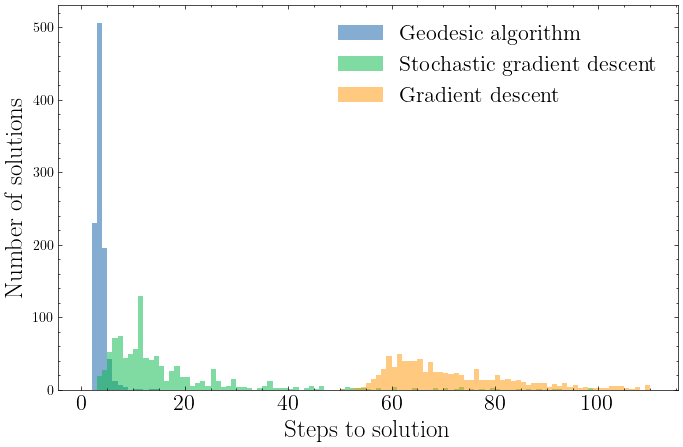

In [162]:
gate = 'toffoli'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]

name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [137]:
from gnd.src.configs import ToffoliConfig as ToffoliConfigGnd
from jax_gd.src.configs import ToffoliConfig

config = ToffoliConfig()
config_gnd = ToffoliConfigGnd()

gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 983/1000
Innocenti: 989/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 982/983
Innocenti: 989/989
Jax GD: 981/1000



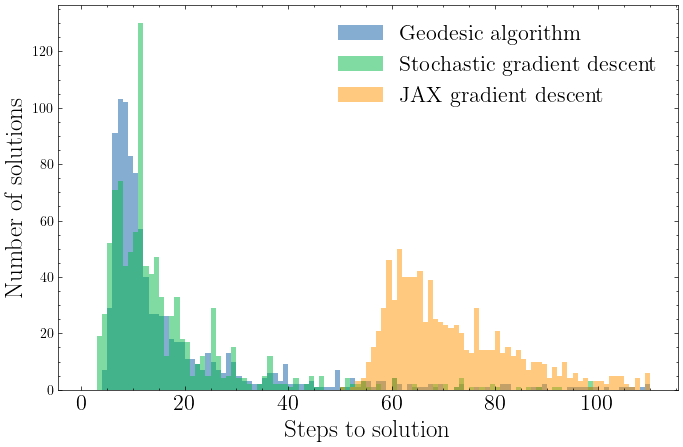

In [121]:
gate = 'toffoli'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name, 
                f"Toffoli ({'Comm.' if commute else 'Non-comm.'})")

# Fredkin

### Commuting

In [146]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 915/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 993/1000
Innocenti: 915/915
Jax GD: 715/1000

Mean time to solution 7.498489425981873
Mean time to solution nan
Mean time to solution 85.8013986013986


/Users/rooler/miniforge38/envs/qqg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rooler/miniforge38/envs/qqg/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


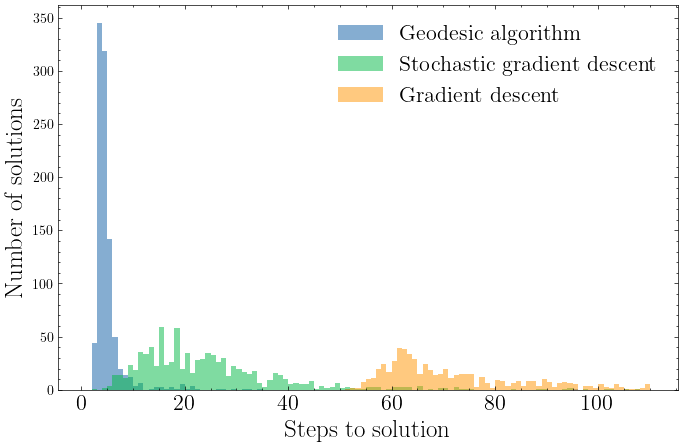

In [163]:
gate = 'fredkin'
ntrials = 1000
commute = True
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]

name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [140]:
from gnd.src.configs import FredkinConfig as FredkinConfigGnd
from jax_gd.src.configs import FredkinConfig

config = FredkinConfig()
config_gnd = FredkinConfigGnd()

gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 892/1000
Innocenti: 915/1000
Jax GD: 1000/1000

Number of solutions with fidelity 0.999:
GND: 884/892
Innocenti: 915/915
Jax GD: 715/1000



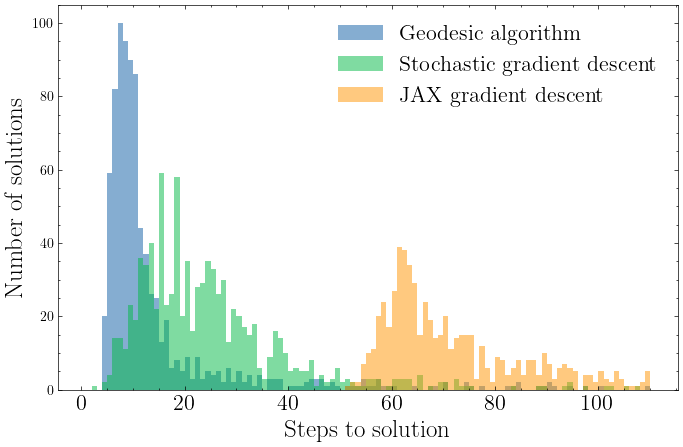

In [119]:
gate = 'fredkin'
ntrials = 1000
commute = False
max_steps = 1000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"Fredkin ({'Comm.' if commute else 'Non-comm.'})")

# C4Not

### Commuting

In [19]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 997/1000
Jax GD: 1000/1000



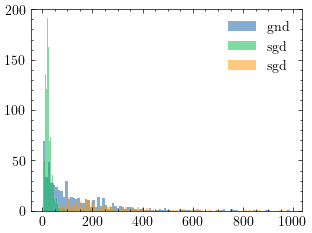

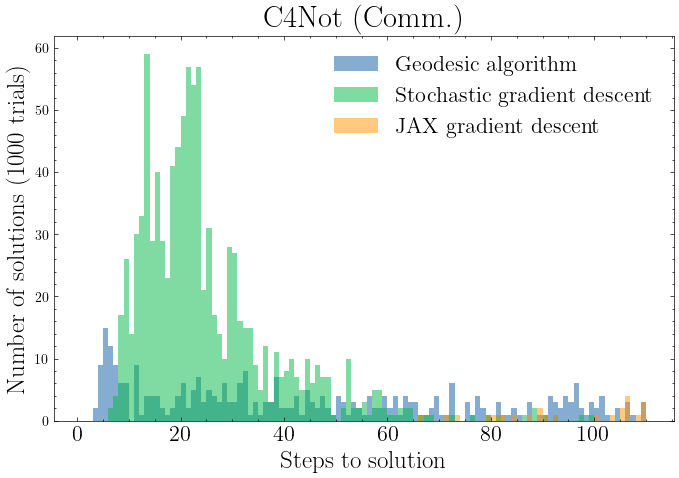

In [52]:
gate = 'c4not'
ntrials = 1000
commute = True
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
num_steps_gnd=np.array(num_steps_gnd)
num_steps_sgd=np.array(num_steps_sgd)
num_steps_jaxgd=np.array(num_steps_jaxgd)

plt.hist(num_steps_gnd[num_steps_gnd<1000], bins=100, alpha=0.5, label='gnd')
plt.hist(num_steps_sgd[num_steps_sgd<1000], bins=100, alpha=0.5, label='sgd')
plt.hist(num_steps_jaxgd[num_steps_jaxgd<1000], bins=100, alpha=0.5, label='sgd')
plt.legend()
plt.show()
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [21]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd
from jax_gd.src.configs import CxNotConfig

config = CxNotConfig(4)
config_gnd = CxNotConfigGnd(4)

gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

config.max_steps = max_steps
config_gnd.max_steps = max_steps
config_gnd.commute = commute

seeds = [n*256 for n in range(1,ntrials+1,1)] 

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = get_data_comparison(config, config_gnd, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"] = (num_steps_gnd, num_steps_sgd, num_steps_jaxgd)

Data integrity: for seed: 256000
GND: 1000/1000
Innocenti: 997/1000
Jax GD: 1000/1000



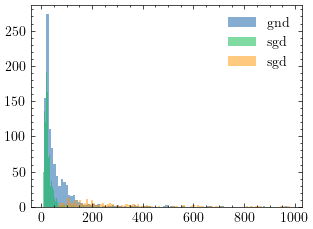

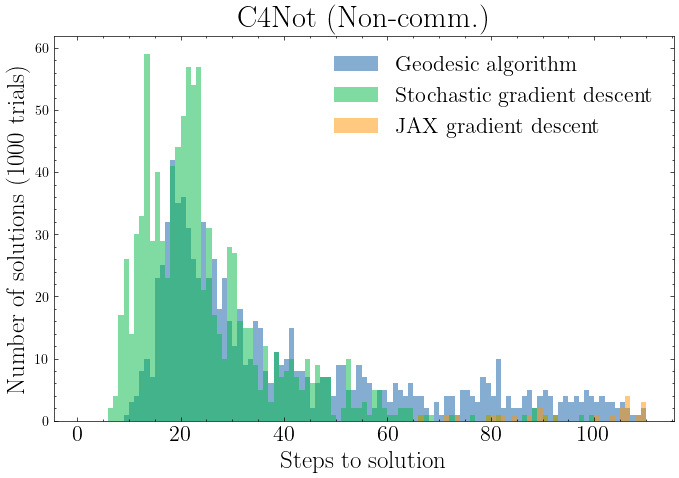

In [55]:
gate = 'c4not'
ntrials = 1000
commute = False
max_steps = 5000

num_steps_gnd, num_steps_sgd, num_steps_jaxgd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}"]
num_steps_gnd=np.array(num_steps_gnd)
num_steps_sgd=np.array(num_steps_sgd)
num_steps_jaxgd=np.array(num_steps_jaxgd)
plt.figure()
plt.hist(num_steps_gnd[num_steps_gnd<1000], bins=100, alpha=0.5, label='gnd')
plt.hist(num_steps_sgd[num_steps_sgd<1000], bins=100, alpha=0.5, label='sgd')
plt.hist(num_steps_jaxgd[num_steps_jaxgd<1000], bins=100, alpha=0.5, label='sgd')
plt.legend()
plt.show()
name = f"plots/{gate}_gate_comparison_max_steps_{max_steps}_commutes_{commute}"
plot_comparison(num_steps_gnd, num_steps_sgd, num_steps_jaxgd, ntrials, name,
                f"C4Not ({'Comm.' if commute else 'Non-comm.'})")

# Fidelity plots
We only consider the non-commuting options here.

# C5Not

### Commuting

In [74]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity: for seed: 2560
GND: 9/10


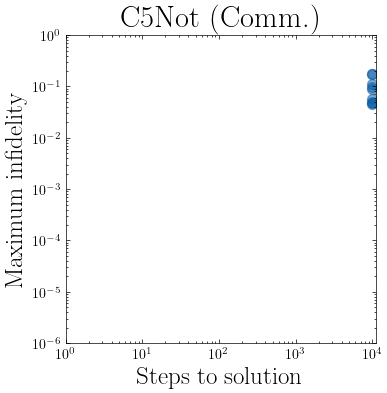

In [87]:
gate = 'c5not'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd= loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [79]:
from gnd.src.configs import CxNotConfig as CxNotConfigGnd

config = CxNotConfigGnd(5)

gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity: for seed: 2560
GND: 10/10


[406, 518, 485, 141, 526, 556, 526, 549, 287, 422] [0.9990234686914978, 0.9990046405897104, 0.9990014091836682, 0.999044591328249, 0.9990017554476344, 0.999011103715409, 0.9990027146802596, 0.9990151346328572, 0.9990010852787852, 0.9990042475164872]


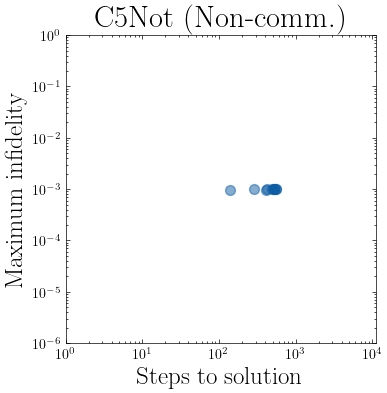

In [86]:
gate = 'c5not'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"C5Not ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityX

### Commuting

In [88]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity:
GND: 0/10


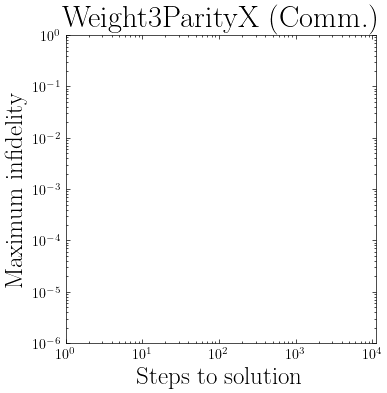

In [90]:
gate = 'w3px'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [111]:
from gnd.src.configs import Weight3ParityXConfig

config = Weight3ParityXConfig()

gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity:
GND: 6/10


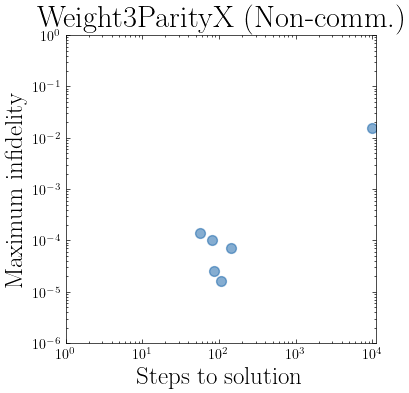

In [112]:
gate = 'w3px'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight3ParityZ

### Commuting

In [94]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity:
GND: 10/10


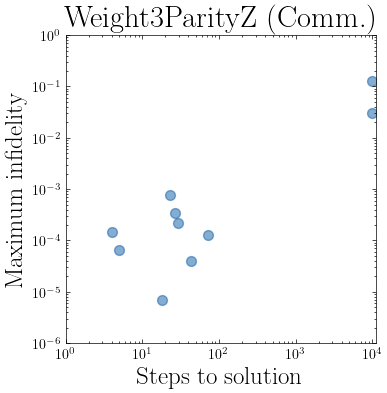

In [95]:
gate = 'w3pz'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd= loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [97]:
from gnd.src.configs import Weight3ParityZConfig

config = Weight3ParityZConfig()

gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity:
GND: 8/10


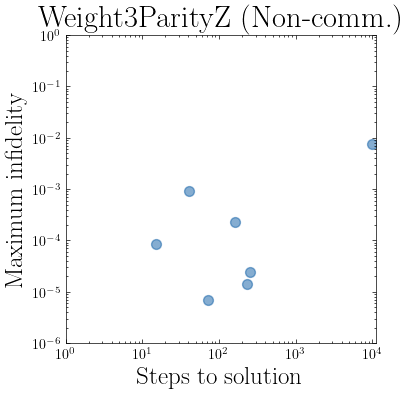

In [98]:
gate = 'w3pz'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight3ParityZ ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityX

### Commuting

In [99]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity:
GND: 0/10


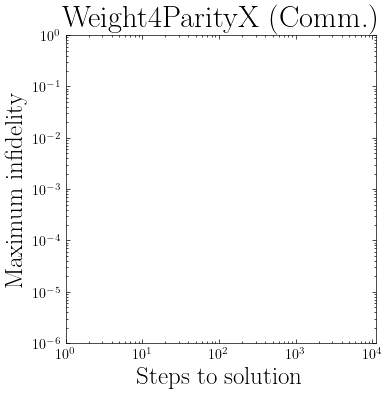

In [100]:
gate = 'w4px'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [101]:
from gnd.src.configs import Weight4ParityXConfig

config = Weight4ParityXConfig()

gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity: for seed: 2560
GND: 8/10


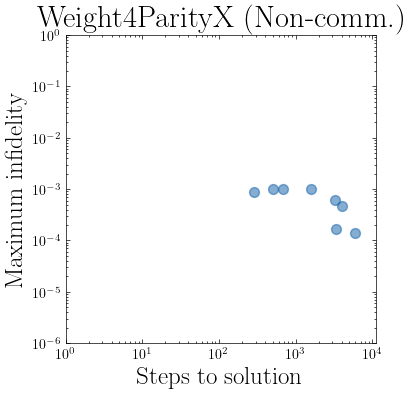

In [103]:
gate = 'w4px'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityX ({'Comm.' if commute else 'Non-comm.'})")

# Weight4ParityZ

### commuting

In [104]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity: for seed: 2560
GND: 5/10


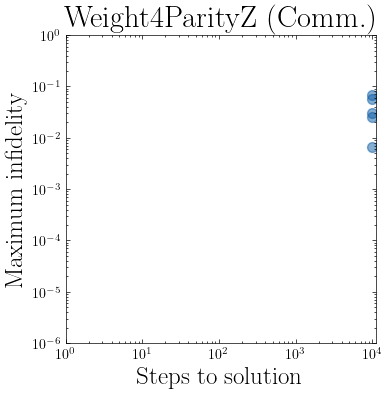

In [105]:
gate = 'w4pz'
ntrials = 10
commute = True
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")

### Non-commuting

In [106]:
from gnd.src.configs import Weight4ParityZConfig

config = Weight4ParityZConfig()

gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

config.max_steps = max_steps
config.max_steps = max_steps
config.commute = commute

seeds = [n*256 for n in range(1, ntrials+1, 1)] 

num_steps_gnd, max_fidelity_gnd = get_data_fidelity(config, seeds)
loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] = (num_steps_gnd, max_fidelity_gnd)

Data integrity: for seed: 2560
GND: 7/10


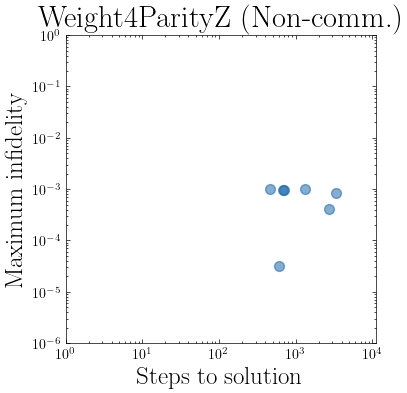

In [107]:
gate = 'w4pz'
ntrials = 10
commute = False
max_steps = 10000

num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"] 
name = f"plots/{gate}_gate_fidelity_max_steps_{max_steps}_commutes_{commute}"
plot_fidelity(num_steps_gnd, max_fidelity_gnd, name, f"Weight4ParityZ ({'Comm.' if commute else 'Non-comm.'})")

# Combined Fidelity plot

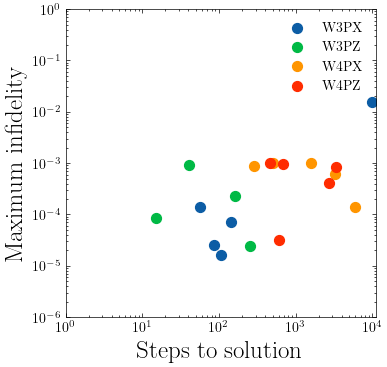

In [126]:
ntrials = 10
commute = False
max_steps = 10000
gate_list = ['w3px','w3pz','w4px','w4pz']

fig, axs = plt.subplots(1,1)
fig.set_size_inches(4,4)
    
for gate in gate_list:
    num_steps_gnd, max_fidelity_gnd = loaded_data[f"{gate}_{ntrials}_{commute}_{max_steps}_fid"]
    axs.scatter(num_steps_gnd[:5], 1 -  np.abs(max_fidelity_gnd)[:5], s=50, label=f"{gate.upper()}")
axs.set_xlabel(f"Steps to solution", fontsize=fontsize_label)
axs.set_ylabel(f"Maximum infidelity", fontsize=fontsize_label)
axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xlim(1, 10**4+1000)
axs.set_ylim(1e-6, 1.)
plt.legend()
plt.savefig(f"./plots/weighted_parity_combined_commute_{commute}.pdf", bbox_inches='tight')
plt.show()